In [32]:
import pypsa 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Einlesen der Datenreihen

In [35]:
# Erzeugung durch Erneuerbare
data_pv = pd.read_csv('data/data_pv_antofagasta_1MW.csv', skiprows = 3)#['electricity']/1000
data_wind = pd.read_csv('data/data_wind_antofagasta_1MW.csv', skiprows = 3)#['electricity']/1000
data_electrolysis = pd.read_excel('data/load_electrolysis.xlsx')['hydrogen']
data_shipping_1 = pd.read_excel('data/Ferntransport.xlsx')['Kapazität [MWh]']
data_shipping_2 = 0

<AxesSubplot:>

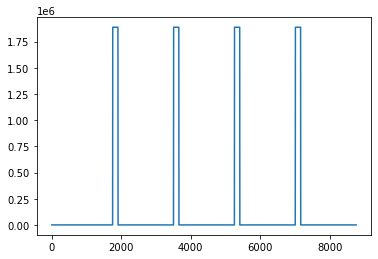

In [38]:
data_shipping_1.plot()

In [40]:
# Erstellung Last
hydrogen_energy_content = 33 #kWh/kg
hydrogen_demand = (35 * 1000) * hydrogen_energy_content * 1000 # MWh
hydrogen_demand_hourly = hydrogen_demand/8760 #MW

print('Der stündliche Bedarf bei konstanter Verteilung des Jahresbedarfs von 35 kt Wasserstoff beträgt ungefähr ' + str(round(hydrogen_demand_hourly,0)) + ' kWh')

#Erstellung Elektrolyseprofil

Der stündliche Bedarf bei konstanter Verteilung des Jahresbedarfs von 35 kt Wasserstoff beträgt ungefähr 131849.0 kWh


In [4]:
hydrogen_demand_hourly

131849.31506849316

In [5]:
# Multilink aufbauen

override_component_attrs = pypsa.descriptors.Dict(
    {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
)
override_component_attrs["Link"].loc["bus2"] = [
    "string",
    np.nan,
    np.nan,
    "2nd bus",
    "Input (optional)",
]
override_component_attrs["Link"].loc["efficiency2"] = [
    "static or series",
    "per unit",
    1.0,
    "2nd bus efficiency",
    "Input (optional)",
]
override_component_attrs["Link"].loc["p2"] = [
    "series",
    "MW",
    0.0,
    "2nd bus output",
    "Output",
]

# Definition der Variablen

## Leistungen

In [6]:
p_nom_pv = data_pv.max()
p_nom_wind = data_wind.max()

## Investitionskosten

In [7]:
# generators
capital_cost_pv = 800 # €/MW
capital_cost_wind = 800 # €/MW

# links
capital_cost_PEMEL = 2500 # €/MW
capital_cost_AEL = 1200 # €/MW
capital_cost_HTEL = 1300 # €/MW
capital_cost_NH3 = 1400 # €/MW
capital_cost_LH2 = 1500 # €/MW
capital_cost_LHOC = 1600 # €/MW
capital_cost_pipeline = 5000 # €/MW
capital_cost_shipping_1 = 10000 # €/MW
capital_cost_shipping_2 = 80000 # €/MW

# storages
capital_cost_storage_GH2 = 200 # €/MW
capital_cost_storage_NH3 = 20 # €/MW
capital_cost_storage_LH2 = 20 # €/MW
capital_cost_storage_LHOC = 20 # €/MW

## Gestehungskosten

In [8]:
# generators
marginal_cost_pv = 70 # €/MWh
marginal_cost_wind = 70 # €/MWh

# conversion
marginal_cost_PEMEL = 1000 # €/MWh
marginal_cost_AEL = 100 # €/MWh
marginal_cost_HTEL = 100 # €/MWh
marginal_cost_NH3 = 100 # €/MWh
marginal_cost_LH2 = 100 # €/MWh
marginal_cost_LHOC = 100 # €/MWh

# storage
marginal_cost_storage_GH2 = 20 # €/MWh
marginal_cost_storage_NH3 = 20 # €/MWh
marginal_cost_storage_LH2 = 20 # €/MWh
marginal_cost_storage_LHOC = 20 # €/MWh

# transportation
marginal_cost_pipeline = 200 # €/MWh
marginal_cost_shipping_GH2 = 10 # €/MWh
marginal_cost_shipping_NH3 = 10 # €/MWh
marginal_cost_shipping_LH2 = 10 # €/MWh
marginal_cost_shipping_LHOC = 10 # €/MWh

## Sonstiges

In [9]:
# efficiencies
efficiency_PEMEL = 0.65
efficiency_AEL = 1
efficiency_HTEL = 1
efficiency_NH3 = 1
efficiency_LH2 = 1
efficiency_LHOC = 1

# lifetimes
lifetime_PEMEL = 20
lifetime_AEL = 20
lifetime_HTEL = 20

# standing losses
standing_loss_GH2 = 0.05
standing_loss_NH3 = 0.05
standing_loss_LH2 = 0.05
standing_loss_LHOC = 0.05

# Netzwerk aufbauen

In [10]:
network = pypsa.Network()
network.set_snapshots(range(8760))

## Buses

In [11]:
network.add('Bus', name = 'electricity')
network.add('Bus', name = 'GH2')
#network.add('Bus', name = 'NH3')
#network.add('Bus', name = 'LH2')
#network.add('Bus', name = 'LHOC')
#network.add('Bus', name = 'hydrogen')

network.add('Bus', name = 'bremerhaven')
#network.add('Bus', name = 'cologne')

## Loads

In [12]:
network.add('Load', name = 'hydrogen_demand', bus = 'bremerhaven', p_set = hydrogen_demand_hourly)

## Generators

In [13]:
network.add('Generator', name = 'pv', bus = 'electricity', 
            p_max_pu = data_pv, p_nom_extendable = True,
            marginal_cost = marginal_cost_pv, capital_cost = capital_cost_pv)

#network.add('Generator', name = 'pv', bus = 'electricity', 
#            p_nom = p_nom_pv, p_max_pu = data_pv/p_nom_pv, p_nom_extendable = True,
#            marginal_cost = marginal_cost_pv, capital_cost = capital_cost_pv)

network.add('Generator', name = 'wind', bus = 'electricity',
            p_nom = p_nom_wind, p_max_pu = data_wind/p_nom_wind, p_nom_extendable = True,
            marginal_cost = marginal_cost_wind, capital_cost = capital_cost_wind)

## Links - Electrolysis

In [14]:
network.add('Link', name = 'PEMEL', bus0 = 'electricity', bus1 = 'bremerhaven', 
            p_nom_extendable = True,
            marginal_cost = marginal_cost_PEMEL, capital_cost = capital_cost_PEMEL,
            efficiency = efficiency_PEMEL)

#network.add('Link', name = 'PEMEL', bus0 = 'electricity', bus1 = 'GH2',
#            p_nom = data_electrolysis.max(), p_max_pu = data_electrolysis/data_electrolysis.max(), 
#            p_nom_extendable = True,
#            marginal_cost = marginal_cost_PEMEL, capital_cost = capital_cost_PEMEL,
#            efficiency = efficiency_PEMEL)

#network.add('Link', name = 'PEMEL', bus0 = 'electricity', bus1 = 'GH2',
#           p_min_pu = 0.8, p_max_pu = 1, p_nom_extendable = True,
#           marginal_cost = marginal_cost_PEMEL, capital_cost = capital_cost_PEMEL,
#           efficiency = efficiency_PEMEL)

network.add('Link', name = 'AEL', bus0 = 'electricity', bus1 = 'GH2',
           p_nom_extendable = True,
           marginal_cost = marginal_cost_AEL, capital_cost = capital_cost_AEL,
           efficiency = efficiency_AEL)
network.add('Link', name = 'HTEL', bus0 = 'electricity', bus1 = 'GH2',
           p_nom_extendable = True,
           marginal_cost = marginal_cost_HTEL, capital_cost = capital_cost_HTEL,
           efficiency = efficiency_HTEL)

## Links - Conversion

network.add('Link', name = 'NH3', bus0 = 'electricity', bus1 = 'NH3',
           p_nom_extendable = True,
           marginal_cost = marginal_cost_NH3, capital_cost = capital_cost_NH3,
           efficiency = efficiency_NH3)

network.add('Link', name = 'LH2', bus0 = 'electricity', bus1 = 'LH2',
           p_nom_extendable = True,
           marginal_cost = marginal_cost_LH2, capital_cost = capital_cost_LH2,
           efficiency = efficiency_LH2)

network.add('Link', name = 'LHOC', bus0 = 'electricity', bus1 = 'LHOC',
           p_nom_extendable = True,
           marginal_cost = marginal_cost_LHOC, capital_cost = capital_cost_LHOC,
           efficiency = efficiency_LHOC)

## Links - Transportation

In [15]:
# long distance shipment
network.add('Link', name = 'Ferntransport_GH2', bus0 = 'GH2', bus1 = 'bremerhaven',
            p_nom = data_shipping_1.max(), p_max_pu = data_shipping_1/data_shipping_1.max(), p_nom_extendable = True,
            marginal_cost = marginal_cost_shipping_GH2, capital_cost = capital_cost_shipping_1)

<AxesSubplot:>

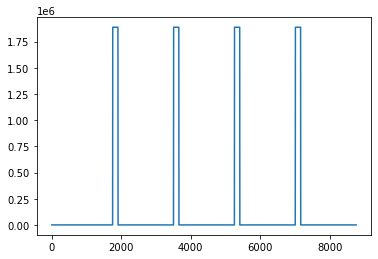

In [16]:
data_shipping_1.plot()

network.add('Link', name = 'Ferntransport_NH3', bus0 = 'NH3', bus1 = 'bremerhaven',
            p_nom = data_shipping_1.max(), p_max_pu = data_shipping_1/data_shipping_1.max(),
            marginal_cost = marginal_cost_shipping_NH3)

network.add('Link', name = 'Ferntransport_LH2', bus0 = 'LH2', bus1 = 'bremerhaven',
            p_nom = data_shipping_1.max(), p_max_pu = data_shipping_1/data_shipping_1.max(),
            marginal_cost = marginal_cost_shipping_LH2)

network.add('Link', name = 'Ferntransport_LHOC', bus0 = 'LHOC', bus1 = 'bremerhaven',
            p_nom = data_shipping_1.max(), p_max_pu = data_shipping_1/data_shipping_1.max(),
            marginal_cost = marginal_cost_shipping_LHOC)

### inland shipment
#TODO: Profil hinterlegen und Links einbauen

## Storages

In [17]:
network.add('Store', name = 'antofagasta_GH2', bus = 'GH2', 
            e_nom_extendable = True,  e_cyclic = True, 
            capital_cost = capital_cost_storage_GH2)

network.add('Store', name = 'hydrogen_store_1.1', bus = 'NH3', 
            e_nom_extendable = True,  e_cyclic = True, 
            capital_cost = capital_cost_storage_NH3)

network.add('Store', name = 'hydrogen_store_1.2', bus = 'LH2', 
            e_nom_extendable = True, e_cyclic = True,  
            capital_cost = capital_cost_storage_LH2)

network.add('Store', name = 'hydrogen_store_1.3', bus = 'LHOC', 
            e_nom_extendable = True, e_cyclic = True,  
            capital_cost = capital_cost_storage_LHOC)

network.add('Store', name = 'bremerhaven_GH2', bus = 'bremerhaven', 
            e_nom_extendable = True, e_cyclic = True, 
            capital_cost = capital_cost_storage_GH2)

network.add('Store', name = 'cologne_GH2', bus = 'cologne', 
            e_nom_extendable = True, e_cyclic = True, 
            capital_cost = capital_cost_storage_GH2)

# Optimierung des Systems

In [18]:
network.lopf(pyomo = False, solver_name = 'gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.21s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-01
Read LP format model from file /var/folders/np/fxyv4bts2s353fj5gdlrbgym0000gn/T/pypsa-problem-l29iy3hr.lp
Reading time = 0.61 seconds
obj: 254040 rows, 140171 columns, 477933 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 254040 rows, 140171 columns and 477933 nonzeros
Model fingerprint: 0x7dc64322
Coefficient statistics:
  Matrix range     [1e-06, 1e+00]
  Objective range  [1e+00, 1e+04]
  Bounds range     [2e+10, 2e+10]
  RHS range        [1e+05, 1e+05]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 213676 rows and 117781 columns
Presolve time: 0.51s
Presolved: 40364 rows, 22390 columns, 102781 nonze

INFO:pypsa.linopf:Optimization successful. Objective value: 1.89e+12


('ok', 'optimal')

# Auswertung der Ergebnisse

In [36]:
def Jahresverlauf (Titel, Zeitstempel, Leistung, xlabel, ylabel):
  # da die DataFrames bereits vorher auf ein Jahr standardisiert werden, muss dies hier nicht passieren
  # diese Funktion erzeugt den Plot
  fig = plt.figure(figsize=(25,10))

 

  ax1 = fig.add_axes([1, 1, 1, 1])
  ax1.set_title(Titel,weight='bold',fontsize=15)
  ax1.plot(Zeitstempel,Leistung,c='green')
  plt.xlabel(xlabel,fontsize=15 )
  plt.ylabel(ylabel,fontsize=15)

 

  plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


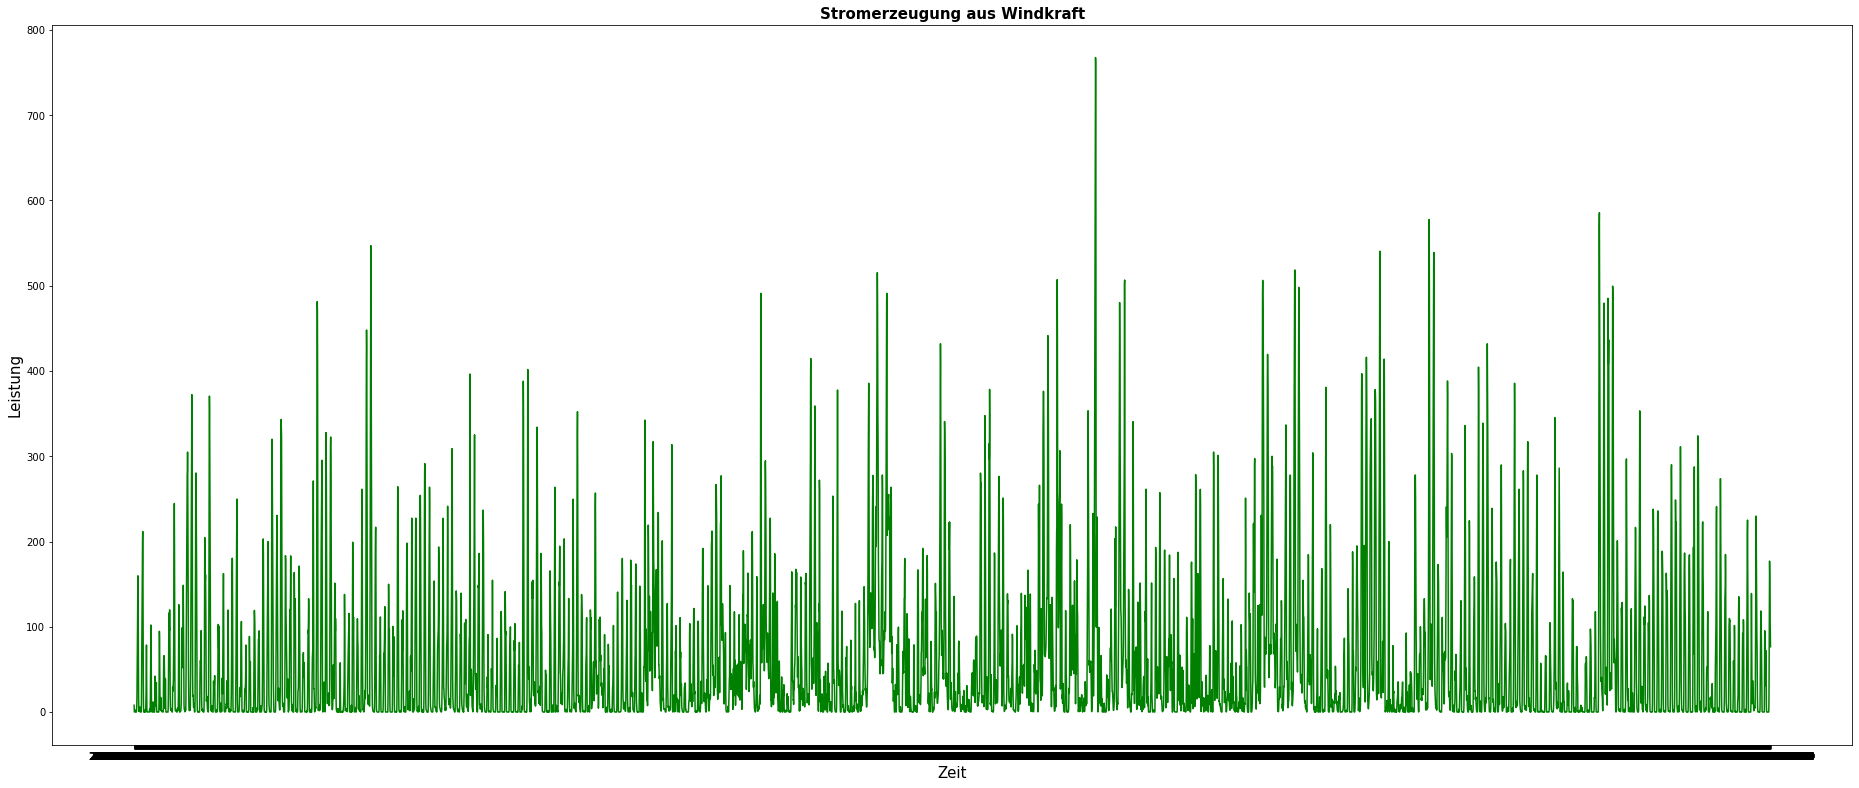

In [37]:
Jahresverlauf('Stromerzeugung aus Windkraft',data_wind.time, data_wind['electricity'],'Zeit','Leistung')

In [19]:
network.generators.p_nom_opt

Generator
pv      1.132706e+06
wind    6.333470e+04
Name: p_nom_opt, dtype: float64

<AxesSubplot:>

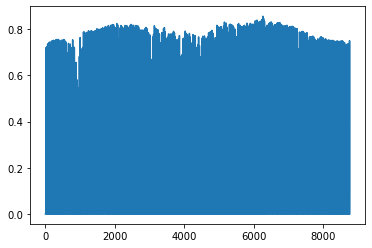

In [20]:
data_pv.plot()

<AxesSubplot:xlabel='snapshot', ylabel='Leistung in GW'>

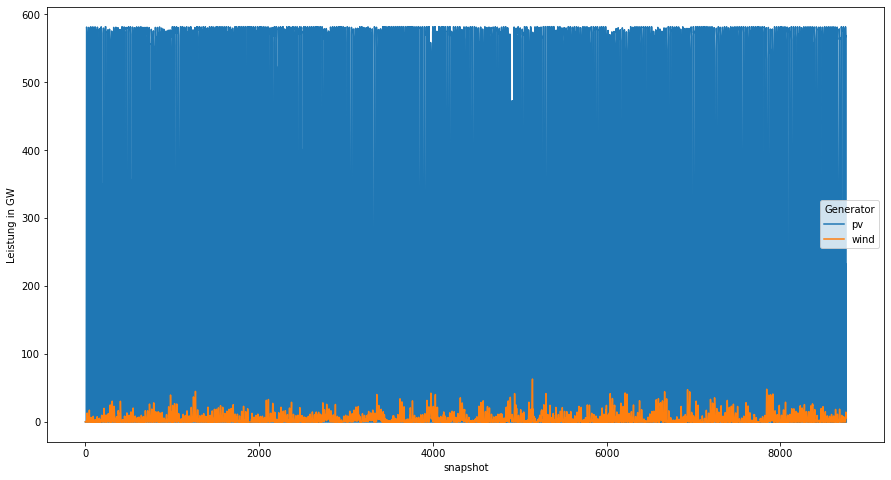

In [21]:
(network.generators_t.p/1000).plot(figsize = (15,8), ylabel = 'Leistung in GW')

<AxesSubplot:>

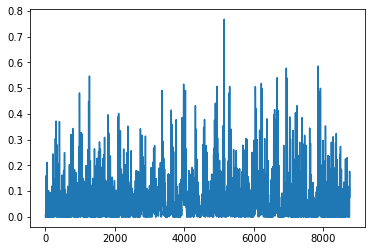

In [22]:
data_wind.plot()

In [23]:
network.generators_t.p['pv'][2400:2424]

snapshot
2400         0.000000
2401         0.000000
2402         0.000000
2403         0.000000
2404         0.000000
2405         0.000000
2406         0.000000
2407         0.000000
2408         0.000000
2409         0.000000
2410         0.000000
2411     86204.620597
2412    353226.561999
2413    130523.912909
2414    581827.002111
2415    581644.661520
2416    580672.157255
2417    578691.301287
2418    577259.367133
2419    576459.196577
2420    496051.777429
2421    234853.079632
2422      5990.884151
2423         0.000000
Name: pv, dtype: float64

In [24]:
network.links_t.p0[2400:2424]

Link,PEMEL,Ferntransport_GH2
snapshot,,
2400,1292.154478,0.0
2401,258.595566,0.0
2402,61.117982,0.0
2403,12.540270,0.0
2404,32.490699,0.0
2405,77.331664,0.0
2406,106.022282,0.0
2407,115.649156,0.0
2408,92.405322,0.0


In [25]:
network.links.p_nom_opt/1000

Link
PEMEL                581.827002
Ferntransport_GH2      0.000000
Name: p_nom_opt, dtype: float64

In [26]:
network.links.p_nom/1000

Link
PEMEL                   0.000000
Ferntransport_GH2    1887.254902
Name: p_nom, dtype: float64

<AxesSubplot:xlabel='snapshot', ylabel='Leistung in GW'>

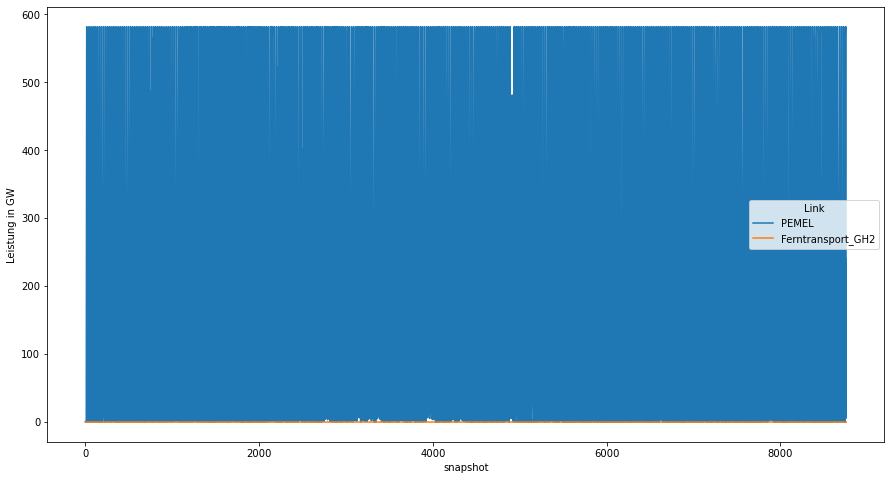

In [27]:
(network.links_t.p0/1000).plot(figsize = (15,8), ylabel = 'Leistung in GW')

<AxesSubplot:xlabel='snapshot', ylabel='Leistung in GW'>

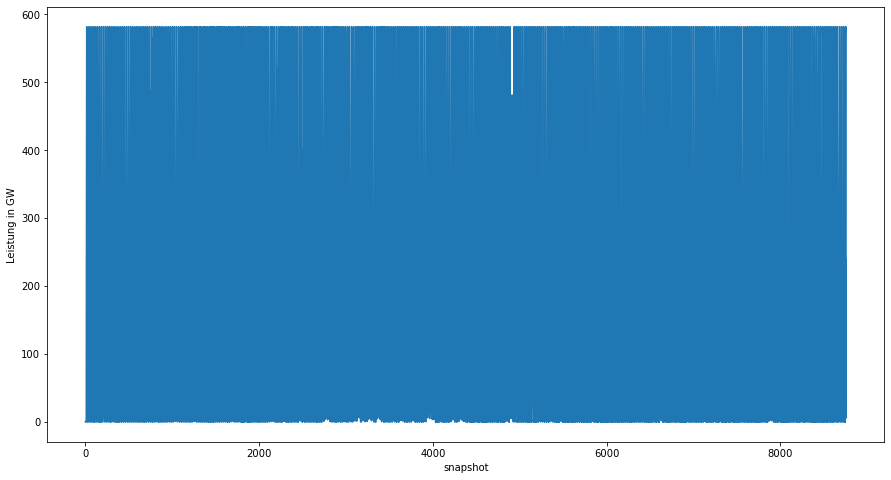

In [28]:
(network.links_t.p0['PEMEL']/1000).plot(figsize = (15,8), ylabel = 'Leistung in GW')

In [29]:
network.stores.e_nom_opt

Store
antofagasta_GH2       0.000000e+00
hydrogen_store_1.1    0.000000e+00
hydrogen_store_1.2    0.000000e+00
hydrogen_store_1.3    0.000000e+00
bremerhaven_GH2       2.911279e+06
cologne_GH2           0.000000e+00
Name: e_nom_opt, dtype: float64

<AxesSubplot:xlabel='snapshot'>

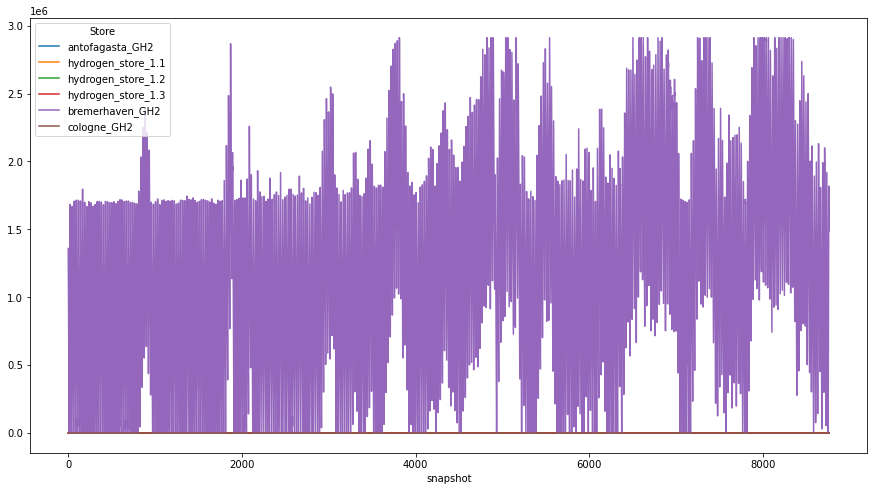

In [30]:
network.stores_t.e.plot(figsize = (15,8))

<AxesSubplot:xlabel='snapshot'>

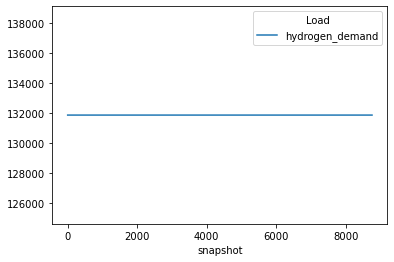

In [31]:
network.loads_t.p.plot()

# Werkstatt